# Vision Transformer (ViT) for Image Classification
Use a Vision Transformer to solve the Cats and Dogs Dataset. You can use pre-defined ViT model or implement from scratch.

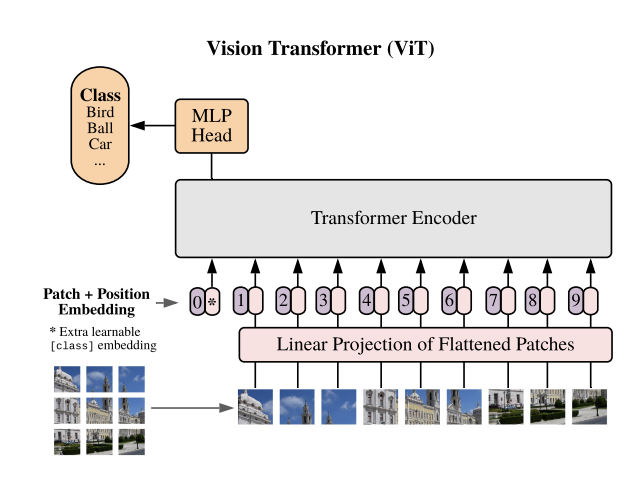

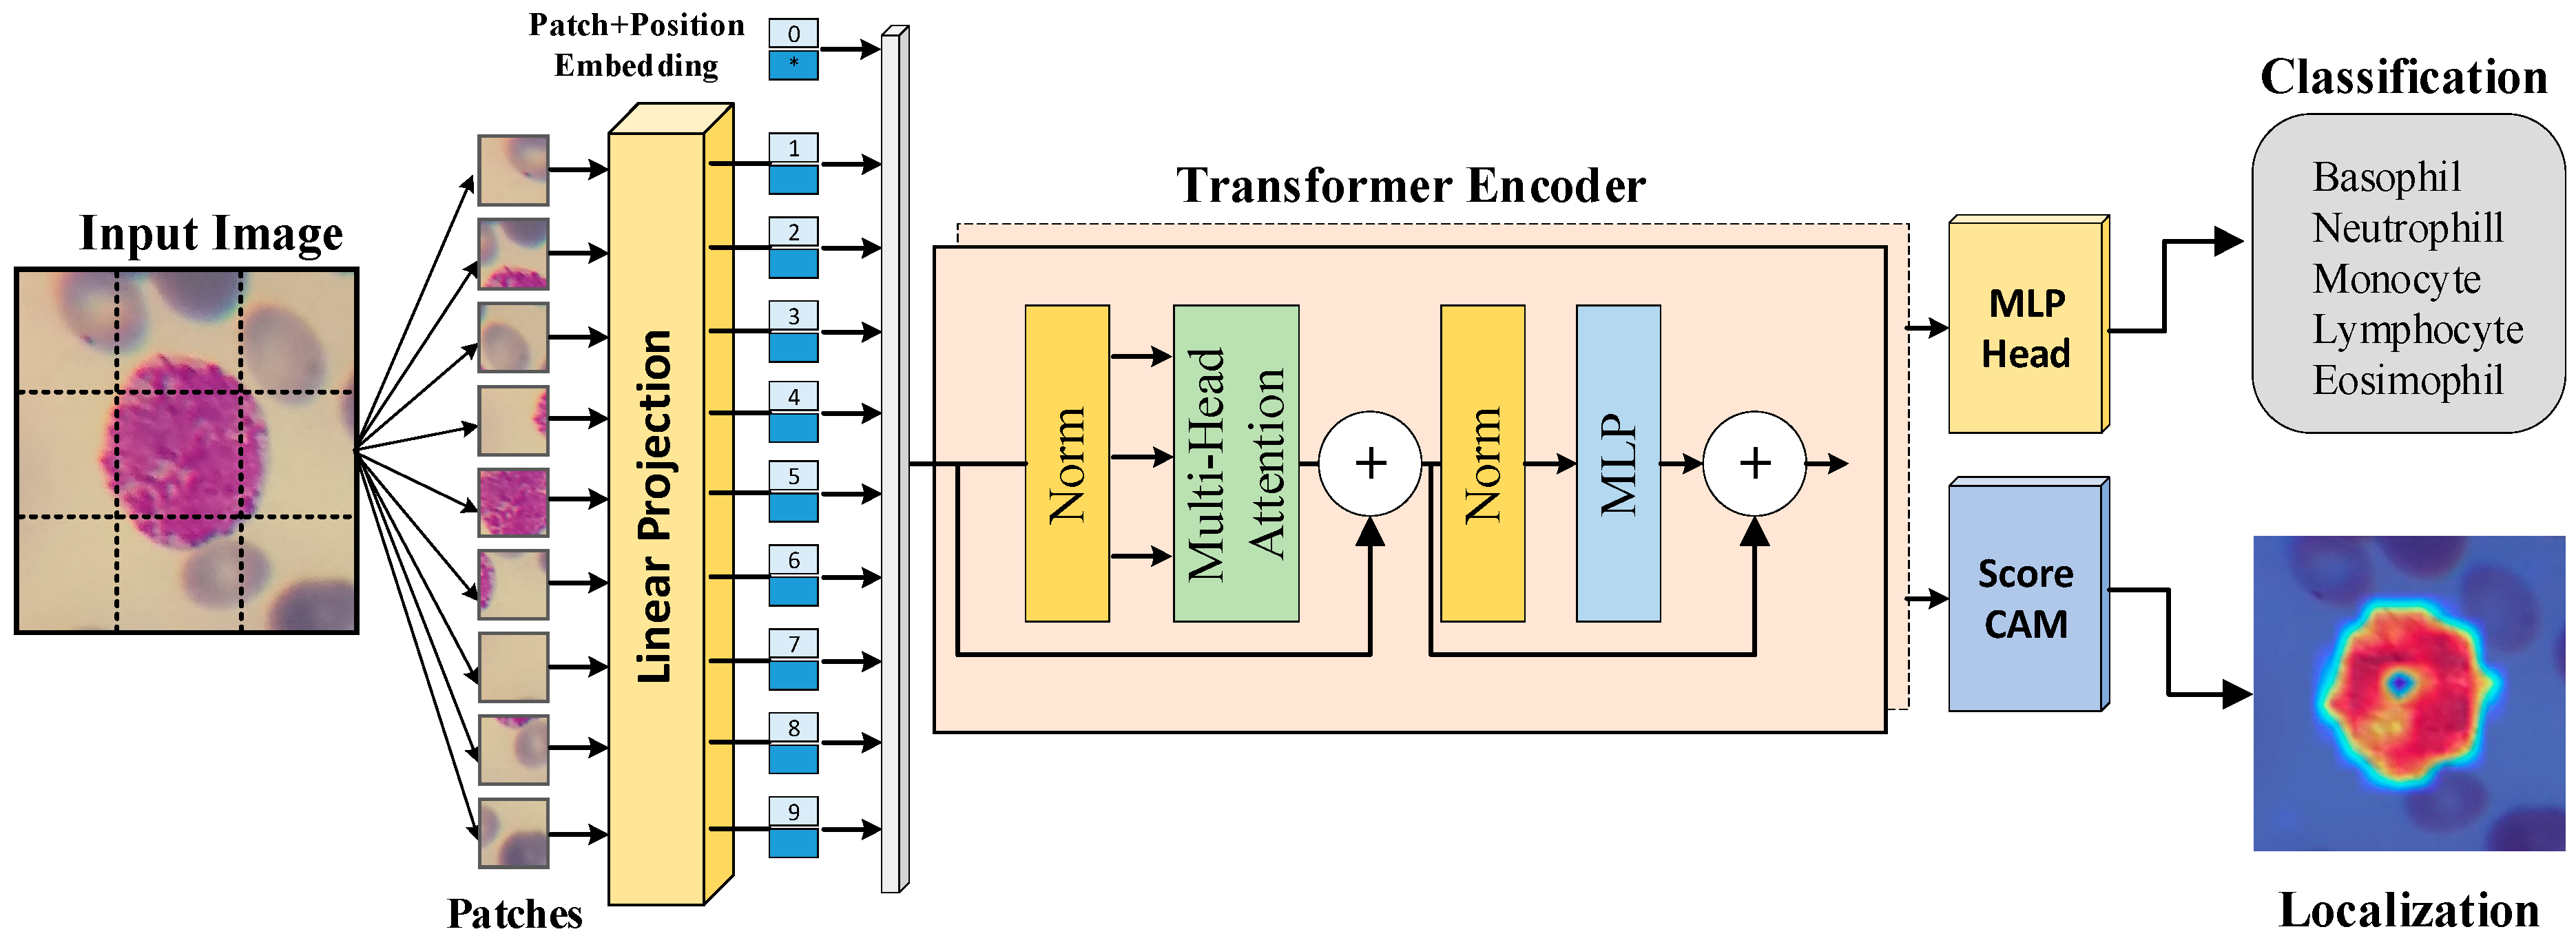

## Steps:

1. Load and preprocess the dataset. This may include resizing images, normalizing pixel values, and splitting the dataset into training, validation, and testing sets.

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!file /content/kagglecatsanddogs_5340.zip

/content/kagglecatsanddogs_5340.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [ ]:
!ls -lh /content/kagglecatsanddogs_5340.zip

-rw-r--r-- 1 root root 5.0M Apr 12 11:46 /content/kagglecatsanddogs_5340.zip


In [ ]:
import zipfile
import os
import tensorflow as tf

zipPath = r"/content/kagglecatsanddogs_5340.zip"
extDir = r"/content/kaggle"

os.makedirs(extDir, exist_ok=True)

try:
    with zipfile.ZipFile(zipPath, 'r') as zf:
        zf.extractall(extDir)
    print("Dataset extracted successfully with zipfile!")
except zipfile.BadZipFile:
    print("BadZipFile error encountered. Falling back to system unzip.")
    os.system(f"unzip {zipPath} -d {extDir}")
    print("Dataset extracted successfully via shell command!")

petImagesDir = os.path.join(extDir, "PetImages")
if os.path.isdir(petImagesDir):
    dataDir = petImagesDir
    print("Using data directory:", dataDir)
else:
    dataDir = extDir
    print("PetImages folder not found. Using directory:", dataDir)

bs = 32
imgH = 224
imgW = 224

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(imgH, imgW),
    batch_size=bs
)

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgH, imgW),
    batch_size=bs
)

normLayer = tf.keras.layers.Rescaling(1./255)
trainDs = trainDs.map(lambda x, y: (normLayer(x), y))
valDs = valDs.map(lambda x, y: (normLayer(x), y))

trainDs = trainDs.apply(tf.data.experimental.ignore_errors())
valDs = valDs.apply(tf.data.experimental.ignore_errors())

autoTune = tf.data.AUTOTUNE
trainDs = trainDs.cache().prefetch(buffer_size=autoTune)
valDs = valDs.cache().prefetch(buffer_size=autoTune)

print("Dataset loaded and preprocessed successfully!")

Dataset extracted successfully with zipfile!
Using data directory: /content/kaggle/PetImages
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Dataset loaded and preprocessed successfully!


#### Dataset Construction:
The code uses TensorFlows image_dataset_from_directory utility directly to create both training & validation datasets from the images in dataDir path. A 20% validation split applies & the data is resized to 224×224 pixels.

#### Normalization:
A Rescaling layer scales the pixel values from a rangle between [0, 255] to [0, 1]. Each of this dataset is mapped through a lambda function that will apply this normalization.

#### Error Handling and Optimization:
Datasets are passed through an error-handling function(ignore_errors()) to skip any corrupt images if there are. Both datasets are then cached & prefetched using tf.data.AUTOTUNE to maximize throughput during the training process.

2. Choose to use a pre-defined ViT model or implement it from scratch. You can use an in-built predefined models for this part.

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers, regularizers

class VitWrapper(layers.Layer):
    def __init__(self, moduleUrl, **kwargs):
        super(VitWrapper, self).__init__(**kwargs)
        self.vitLayer = hub.KerasLayer(
            moduleUrl,
            trainable=False,
            signature="serving_default",
            signature_outputs_as_dict=True
        )

    def call(self, inputs):
        outputDict = self.vitLayer({"inputs": inputs})
        return outputDict["output_0"]

dataAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
], name="dataAug")

inputShape = (224, 224, 3)
inputs = tf.keras.Input(shape=inputShape)

xVar = dataAug(inputs)
vitUrl = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
vitOut = VitWrapper(vitUrl, name="vitWrapper")(xVar)

xVar = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="dense1")(vitOut)
xVar = layers.BatchNormalization(name="bn1")(xVar)
xVar = layers.Dropout(0.4, name="dropout1")(xVar)
xVar = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="dense2")(xVar)
xVar = layers.BatchNormalization(name="bn2")(xVar)
xVar = layers.Dropout(0.3, name="dropout2")(xVar)
numClasses = 2
outputs = layers.Dense(numClasses, activation="softmax", name="predictions")(xVar)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="vitModel")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "vitModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dataAug (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vitWrapper (VitWrapper)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,210 (1.76 MB)

 Trainable params: 460,930 (1.76 MB)

 Non-trainable params: 1,280 (5.00 KB)

3. Train and evaluate your ViT model. Discuss your results.

In [ ]:
import matplotlib.pyplot as plot
import tensorflow as tf

numEpochs = 5
batchSize = 32

earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduceLr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    "bestVitModel.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

callBacks = [earlyStop, reduceLr, modelCheckpoint]

trainDsLimited = trainDs.take(100)
valDsLimited = valDs.take(25)

history = model.fit(
    trainDsLimited,
    validation_data=valDsLimited,
    epochs=numEpochs,
    callbacks=callBacks,
    verbose=1
)

print("Training completed. Best validation loss is : {:.4f}".format(min(history.history["val_loss"])))

Epoch 1/5
    100/Unknown 50s 365ms/step - accuracy: 0.8520 - loss: 0.4359

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.09957, saving model to bestVitModel.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 482ms/step - accuracy: 0.8528 - loss: 0.4342 - val_accuracy: 0.9937 - val_loss: 0.0996 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9842 - loss: 0.1301
Epoch 2: val_loss did not improve from 0.09957
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step - accuracy: 0.9842 - loss: 0.1301 - val_accuracy: 0.9937 - val_loss: 0.1027 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9894 - loss: 0.1188
Epoch 3: val_loss improved from 0.09957 to 0.09205, saving model to bestVitModel.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 443ms/step - accuracy: 0.9895 - loss: 0.1188 - val_accuracy: 0.9975 - val_loss: 0.0920 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9926 - loss: 0.1106
Epoch 4: val_loss did not improve from 0.09205
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - accuracy: 0.9926 - loss: 0.1106 - val_accuracy: 0.9975 - val_loss: 0.0922 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9929 - loss: 0.1080
Epoch 5: val_loss improved from 0.09205 to 0.08734, saving model to bestVitModel.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.9928 - loss: 0.1080 - val_accuracy: 0.9975 - val_loss: 0.0873 - learning_rate: 1.0000e-04
Training completed. Best validation loss is : 0.0873


Three callbacks are given below from the code above;

1. EarlyStopping: It stops the training if validation loss wont improve for 3
consecutive epochs.
2. ReduceLROnPlateau: It reduces the learning rate(lr) if the validation loss will plateau.
3. ModelCheckpoint: It saves the model to bestVitModel.h5 every time a new minimum validation loss is reached.

To manage system resources, the training uses a limited number of batches making use of the .take() method for both training as well as validation datasets.

Visualisation

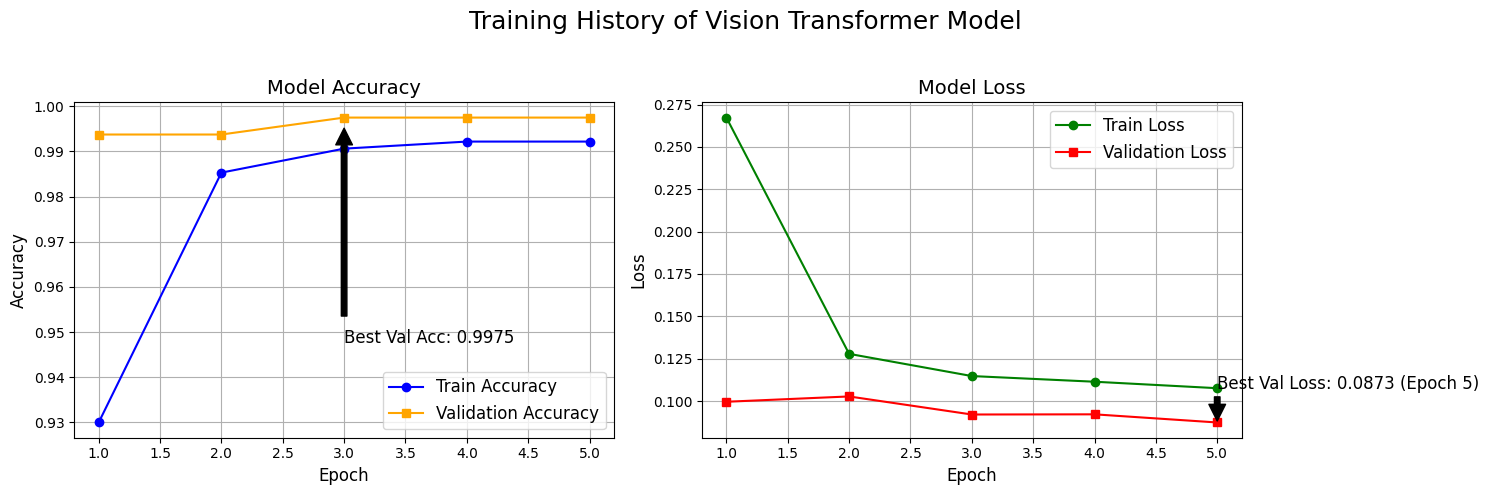

In [ ]:
import matplotlib.pyplot as plot
import numpy as np

epochsRange = np.arange(1, len(history.history["accuracy"]) + 1)
trainAcc = history.history["accuracy"]
valAcc = history.history["val_accuracy"]
trainLoss = history.history["loss"]
valLoss = history.history["val_loss"]

bestEpoch = np.argmin(valLoss) + 1
bestValLoss = np.min(valLoss)

fig, (axis1, axis2) = plot.subplots(1, 2, figsize=(15, 5))

axis1.plot(epochsRange, trainAcc, 'o-', color='blue', label="Train Accuracy")
axis1.plot(epochsRange, valAcc, 's-', color='orange', label="Validation Accuracy")
axis1.set_title("Model Accuracy", fontsize=14)
axis1.set_xlabel("Epoch", fontsize=12)
axis1.set_ylabel("Accuracy", fontsize=12)
axis1.legend(fontsize=12)
axis1.grid(True)
bestValAcc = max(valAcc)
bestValAccEpoch = np.argmax(valAcc) + 1
axis1.annotate(f"Best Val Acc: {bestValAcc:.4f}",
               xy=(bestValAccEpoch, bestValAcc),
               xytext=(bestValAccEpoch, bestValAcc - 0.05),
               arrowprops=dict(facecolor='black', shrink=0.05),
               fontsize=12)

axis2.plot(epochsRange, trainLoss, 'o-', color='green', label="Train Loss")
axis2.plot(epochsRange, valLoss, 's-', color='red', label="Validation Loss")
axis2.set_title("Model Loss", fontsize=14)
axis2.set_xlabel("Epoch", fontsize=12)
axis2.set_ylabel("Loss", fontsize=12)
axis2.legend(fontsize=12)
axis2.grid(True)
axis2.annotate(f"Best Val Loss: {bestValLoss:.4f} (Epoch {bestEpoch})",
               xy=(bestEpoch, bestValLoss),
               xytext=(bestEpoch, bestValLoss + 0.02),
               arrowprops=dict(facecolor='black', shrink=0.05),
               fontsize=12)

fig.suptitle("Training History of Vision Transformer Model", fontsize=18, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plot.show()

The plot shows training & validation accuracy on the left, & training & validation loss on the right side.

4. Deploy your trained ViT model. This could be a simple script or application that takes an image as input and predicts whether it's a cat or a dog.

1. Deployment Custom Layer(VitWrapper): This is the deployment version of the custom layer. It wraps the TensorFlow Hub ViT module with a familiar signature that guarantees proper processing of images during inference time.

2. If you are loading the model for inference:
Load the trained model using tf.keras.models.load_model with a custom object mapping for VitWrapper so that the model's architecture is rebuilt correctly.

3. Prediction Function (predict_image): This function takes in an input image (using Gradio's built-in PIL image type), converts it to RGB, resizes it to 224×224, normalizes the pixel values, adds the batch dimension, and runs inference. The predicted index is then mapped to the human-readable class label ("Cat"/"Dog").

4. Gradio UI Setup: Gradio is used to set up an interactive UI. The interface takes an image as input & outputs the prediction text, be it a cat or a dog. The iface.launch() command launches a local web server for users to interact.

In [ ]:
!pip install pillow-avif-plugin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.4 MB/s eta 0:00:00


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow_hub as hub
from tensorflow.keras import layers

class VitWrapper(layers.Layer):
    def __init__(self, moduleUrl, **kwargs):
        super(VitWrapper, self).__init__(**kwargs)
        self.moduleUrl = moduleUrl
        self.vitLayer = hub.KerasLayer(
            moduleUrl,
            trainable=False,
            signature="serving_default",
            signature_outputs_as_dict=True
        )
    def call(self, inputs):
        out = self.vitLayer({"inputs": inputs})
        return out["output_0"]
    def get_config(self):
        config = super(VitWrapper, self).get_config()
        config.update({"moduleUrl": self.moduleUrl})
        return config

model = tf.keras.models.load_model("bestVitModel.h5", custom_objects={"VitWrapper": VitWrapper})

def predict_image(img):
    img = img.convert("RGB").resize((224, 224))
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    preds = model.predict(arr)
    idx = np.argmax(preds, axis=1)[0]
    return ["Cat", "Dog"][idx]

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Cat vs Dog Classifier",
    description="Upload an image and the model will predict whether it is a cat or a dog."
)
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ca530c8eb6d769d1fb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


6. References. Include details on all the resources used to complete this part.

1. https://arxiv.org/abs/2010.11929
2. https://www.tensorflow.org/guide/keras/serialization_and_saving
3. https://github.com/google-research/vision_transformer
4. https://github.com/gradio-app/gradio
5. https://en.wikipedia.org/wiki/Vision_transformer
6. https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6: The best
7. https://huggingface.co/docs/transformers/main/en/model_doc/vit